In [26]:
import sys
sys.path.append("..")
from lib.kalman_gst import *  
from pygsti.modelpacks import smq1Q_XYZI as std

In [135]:
NUM_SHOTS = 256

In [27]:
def avg_eigenvalue_entanglement_infidel(model, noise_model, basis='pp'):
    aei = 0
    for op in list(model.operations.keys()):
        mdl_mat = model[op].to_dense()
        aei += pygsti.report.entanglement_infidelity(mdl_mat, noise_model[op].to_dense(), basis)
    return aei/len(list(model.operations.keys()))

In [28]:
# make an edesign
target_model = std.target_model('CPTP')
maxLengths = [1,2,4, 8]
edesign = pygsti.protocols.StandardGSTDesign(std.target_model('CPTP'), std.prep_fiducials(), std.meas_fiducials(),
                                                std.germs(), maxLengths)

In [119]:
# make a random noise model
mdl_datagen = std.target_model('full')
mdl_datagen = mdl_datagen.randomize_with_unitary(0.05)
mdl_datagen = mdl_datagen.depolarize(0.00001)

In [127]:
aei = avg_eigenvalue_entanglement_infidel(mdl_datagen, target_model)
print(aei)

0.01893345509462796


In [124]:
def total_design_matrix(model, circuit_list):
    """
    calculates the total design matrix at the location given by the model
    """
    
    H_tot = np.zeros((0, model.num_params))
    for circ in circuit_list:
        H_tot = np.vstack((H_tot, matrix_from_jacob(model.sim.dprobs(circ), 2**circ.width)))
    return H_tot

In [160]:
class PoissonKalmanFilter():
    def __init__(self, model, P0):
        self.model = model.copy()
        self.P = P0
        
        self.param_hist = [model.to_vector()]
        self.covar_hist = [self.P]
        
        self.observability_transform = np.eye(self.model.num_params)
        
    def update(self, circ, count_vec, Q=None):
        prior_covar = self.P
        x_prior = self.model.to_vector()
        hilbert_dims = 2**(circ.width)
        
        jacob = matrix_from_jacob(self.model.sim.dprobs(circ), 2**circ.width)
        jacob = jacob@self.observability_transform
        
        P = prior_covar
        if Q is not None:
            P += Q
        
        p_pred = vector_from_outcomes(self.model.probabilities(circ), hilbert_dims)
        N_counts = sum(count_vec)
        c_pred = N_counts*p_pred
        
        obs_covar = np.diag(c_pred+np.ones(len(c_pred)))
        obs_mat = N_counts*jacob
        
        Kgain = P@obs_mat.T@np.linalg.inv(obs_mat@P@obs_mat.T + obs_covar)
        
        x_post = x_prior + Kgain@(count_vec - c_pred)
        
        covar_proj = np.eye(P.shape[0]) - Kgain@obs_mat
        post_covar = covar_proj@P@covar_proj.T + Kgain@obs_covar@Kgain.T
        
        self.param_hist.append(x_post)
        self.covar_hist.append(post_covar)
        
        self.model.from_vector(self.observability_transform.T@x_post)
        self.P = post_covar
        
    def set_observability_matrix(self, circuit_list):
        H_tot = total_design_matrix(self.model, circuit_list)
        s, d, vt = np.linalg.svd(H_tot)
        self.observability_transform = vt.T
        
    def observe_model(self, mdl_in, circ_list, total_counts):
        for circ in tqdm(circ_list):
            obs_pvec = vector_from_outcomes(mdl_in.probabilities(circ), 2**circ.width)
            obs_pvec = np.clip(obs_pvec, 0, 1)
            obs_cvec = np.random.multinomial(total_counts, obs_pvec)
            self.update(circ, obs_cvec)

In [161]:
prior_covar = aei**2*np.eye(target_model.num_params)

In [165]:
circ_list = edesign.circuit_lists[0]
pkf1 = PoissonKalmanFilter(target_model, prior_covar)
pkf1.observe_model(mdl_datagen, circ_list, 256)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:11<00:00, 11.44it/s]


Text(0, 0.5, 'MSE [log]')

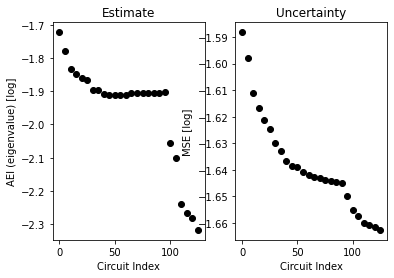

In [166]:
model_vectors = pkf1.param_hist
filter_covars = pkf1.covar_hist
y_range = None

fig, axs = plt.subplots(1, 2)

axs[0].set_title('Estimate')
axs[1].set_title('Uncertainty')

fid_model = pkf1.model.copy()

for i in range(0, len(model_vectors), plt_spacing):
    params = model_vectors[i]
    fid_model.from_vector(params)
    error = np.log10(avg_eigenvalue_entanglement_infidel(mdl_datagen, fid_model))
    axs[0].scatter(i, error, c='black')
    axs[1].scatter(i, np.log10((np.trace(filter_covars[i]))), c='black')


axs[0].set_xlabel('Circuit Index')
axs[1].set_xlabel('Circuit Index')
axs[0].set_ylabel('AEI (eigenvalue) [log]')
axs[1].set_ylabel('MSE [log]')

In [167]:
pkf2 = PoissonKalmanFilter(target_model, prior_covar)
pkf2.set_observability_matrix(edesign.circuit_lists[0])

In [168]:
pkf2.observe_model(mdl_datagen, edesign.circuit_lists[0], 256)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:11<00:00, 11.09it/s]


Text(0, 0.5, 'MSE [log]')

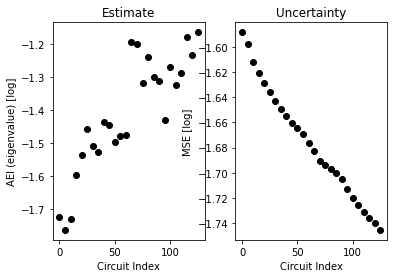

In [169]:
model_vectors = pkf2.param_hist
filter_covars = pkf2.covar_hist
y_range = None

fig, axs = plt.subplots(1, 2)

axs[0].set_title('Estimate')
axs[1].set_title('Uncertainty')

fid_model = pkf1.model.copy()

for i in range(0, len(model_vectors), plt_spacing):
    params = model_vectors[i]
    fid_model.from_vector(pkf2.observability_transform.T@params)
    error = np.log10(avg_eigenvalue_entanglement_infidel(mdl_datagen, fid_model))
    axs[0].scatter(i, error, c='black')
    axs[1].scatter(i, np.log10((np.trace(filter_covars[i]))), c='black')


axs[0].set_xlabel('Circuit Index')
axs[1].set_xlabel('Circuit Index')
axs[0].set_ylabel('AEI (eigenvalue) [log]')
axs[1].set_ylabel('MSE [log]')